# 02 - Pipeline Completo: Entrenamiento y Evaluación

**Objetivo:** Entrenar múltiples modelos de ML/DL y comparar resultados

**Modelos:**
1. Logistic Regression (baseline)
2. Random Forest
3. XGBoost
4. Support Vector Machine (SVM)
5. Red Neuronal (MLP)
6. Ensemble (Voting Classifier)

**Accuracy Esperado:** 95-98%

**Autores:** Hernán Zamorano y Martín Navarro  
**Universidad:** O'Higgins - COM4202

## 1. Imports y Configuración

In [ ]:
!pip install xgboost
!pip install tensorflow

^C


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/331.7 MB ? eta -:--:--
    --------------------------------------- 6.0/331.7 MB 30.7 MB/s eta 0:00:11
   - -------------------------------------- 11.5/331.7 MB 28.8 MB/s eta 0:00:12
   - -------------------------------------- 16.0/331.7 MB 25.8 MB/s eta 0:00:13
   -- ------------------------------------- 22.3/331.7 MB 27.1 MB/s eta 0:00:12
   --- ------------------------------------ 29.1/331.7 MB 28.8 MB/s eta 0:00:11
   ---- ----------------------------------- 35.4/331.7 MB 28.8 MB/s eta 0:00:11
   ----- ---------------------------------- 42.2/331.7 MB 29.2 MB/s eta 0:00:10
   ----- ---------------------------------- 48.5/331.7 MB 29.4 MB/s eta

In [5]:
!pip install tensorflow

  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl (331.7 MB)


ERROR: Could not install packages due to an OSError: [WinError 32] El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso: 'C:\\Users\\herna\\AppData\\Local\\conda\\conda\\envs\\neuralgcm-env\\Lib\\site-packages\\tensorflow\\python\\_pywrap_tensorflow_common.dll'
Consider using the `--user` option or check the permissions.



In [6]:
# Imports generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Imports de scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# XGBoost
import xgboost as xgb

# TensorFlow/Keras para redes neuronales
from tensorflow import keras
from tensorflow.keras import layers

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports completados")

✓ Imports completados


## 2. Carga de Datos Procesados

In [7]:
# Cargar datos del notebook anterior
print("Cargando datos procesados...")
data = np.load('data_processed/breast_cancer_processed.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
feature_names = data['feature_names']
target_names = data['target_names']

print(f"\n{'='*70}")
print("DATOS CARGADOS")
print(f"{'='*70}")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")
print(f"\n✓ Datos listos para entrenamiento")

Cargando datos procesados...

DATOS CARGADOS
X_train: (455, 30)
X_test:  (114, 30)
y_train: (455,)
y_test:  (114,)

✓ Datos listos para entrenamiento


## 3. Definición de Modelos

### 3.1 Función para construir Red Neuronal (MLP)

In [8]:
def build_mlp_model(input_dim, name='MLP_BreastCancer'):
    """
    Construir Red Neuronal optimizada para clasificación binaria
    
    Arquitectura:
    - Input layer: input_dim features
    - Hidden 1: 64 neurons + BatchNorm + Dropout(0.3)
    - Hidden 2: 32 neurons + BatchNorm + Dropout(0.2)
    - Output: 1 neuron sigmoid (probabilidad)
    """
    model = keras.Sequential([
        # Input
        layers.Input(shape=(input_dim,)),
        
        # Capa oculta 1
        layers.Dense(64, activation='relu', name='hidden1'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Capa oculta 2
        layers.Dense(32, activation='relu', name='hidden2'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output
        layers.Dense(1, activation='sigmoid', name='output')
    ], name=name)
    
    # Compilar
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

print("✓ Función build_mlp_model definida")

✓ Función build_mlp_model definida


## 4. Entrenamiento de Modelos

### 4.1 Modelo 1: Logistic Regression (Baseline)

In [9]:
print("\n" + "="*70)
print("MODELO 1: LOGISTIC REGRESSION")
print("="*70)

# Entrenar
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predicciones
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Métricas
lr_metrics = {
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr_pred_proba)
}

print(f"Accuracy:  {lr_metrics['accuracy']:.4f}")
print(f"Precision: {lr_metrics['precision']:.4f}")
print(f"Recall:    {lr_metrics['recall']:.4f}")
print(f"F1-Score:  {lr_metrics['f1']:.4f}")
print(f"ROC-AUC:   {lr_metrics['roc_auc']:.4f}")
print("\n✓ Logistic Regression entrenado")


MODELO 1: LOGISTIC REGRESSION
Accuracy:  0.9825
Precision: 0.9861
Recall:    0.9861
F1-Score:  0.9861
ROC-AUC:   0.9954

✓ Logistic Regression entrenado


### 4.2 Modelo 2: Random Forest

In [10]:
print("\n" + "="*70)
print("MODELO 2: RANDOM FOREST")
print("="*70)

# Entrenar
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predicciones
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Métricas
rf_metrics = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf_pred_proba)
}

print(f"Accuracy:  {rf_metrics['accuracy']:.4f}")
print(f"Precision: {rf_metrics['precision']:.4f}")
print(f"Recall:    {rf_metrics['recall']:.4f}")
print(f"F1-Score:  {rf_metrics['f1']:.4f}")
print(f"ROC-AUC:   {rf_metrics['roc_auc']:.4f}")
print("\n✓ Random Forest entrenado")


MODELO 2: RANDOM FOREST
Accuracy:  0.9474
Precision: 0.9583
Recall:    0.9583
F1-Score:  0.9583
ROC-AUC:   0.9931

✓ Random Forest entrenado


### 4.3 Modelo 3: XGBoost

In [11]:
print("\n" + "="*70)
print("MODELO 3: XGBOOST")
print("="*70)

# Entrenar
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train, verbose=False)

# Predicciones
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Métricas
xgb_metrics = {
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision': precision_score(y_test, xgb_pred),
    'recall': recall_score(y_test, xgb_pred),
    'f1': f1_score(y_test, xgb_pred),
    'roc_auc': roc_auc_score(y_test, xgb_pred_proba)
}

print(f"Accuracy:  {xgb_metrics['accuracy']:.4f}")
print(f"Precision: {xgb_metrics['precision']:.4f}")
print(f"Recall:    {xgb_metrics['recall']:.4f}")
print(f"F1-Score:  {xgb_metrics['f1']:.4f}")
print(f"ROC-AUC:   {xgb_metrics['roc_auc']:.4f}")
print("\n✓ XGBoost entrenado")


MODELO 3: XGBOOST
Accuracy:  0.9474
Precision: 0.9459
Recall:    0.9722
F1-Score:  0.9589
ROC-AUC:   0.9934

✓ XGBoost entrenado


### 4.4 Modelo 4: Support Vector Machine (SVM)

In [12]:
print("\n" + "="*70)
print("MODELO 4: SUPPORT VECTOR MACHINE")
print("="*70)

# Entrenar
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)
svm_model.fit(X_train, y_train)

# Predicciones
svm_pred = svm_model.predict(X_test)
svm_pred_proba = svm_model.predict_proba(X_test)[:, 1]

# Métricas
svm_metrics = {
    'accuracy': accuracy_score(y_test, svm_pred),
    'precision': precision_score(y_test, svm_pred),
    'recall': recall_score(y_test, svm_pred),
    'f1': f1_score(y_test, svm_pred),
    'roc_auc': roc_auc_score(y_test, svm_pred_proba)
}

print(f"Accuracy:  {svm_metrics['accuracy']:.4f}")
print(f"Precision: {svm_metrics['precision']:.4f}")
print(f"Recall:    {svm_metrics['recall']:.4f}")
print(f"F1-Score:  {svm_metrics['f1']:.4f}")
print(f"ROC-AUC:   {svm_metrics['roc_auc']:.4f}")
print("\n✓ SVM entrenado")


MODELO 4: SUPPORT VECTOR MACHINE
Accuracy:  0.9825
Precision: 0.9861
Recall:    0.9861
F1-Score:  0.9861
ROC-AUC:   0.9950

✓ SVM entrenado


### 4.5 Modelo 5: Red Neuronal (MLP)

In [13]:
print("\n" + "="*70)
print("MODELO 5: RED NEURONAL (MLP)")
print("="*70)

# Construir modelo
mlp_model = build_mlp_model(input_dim=X_train.shape[1])
mlp_model.summary()

# Callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=0
)

print("\nEntrenando Red Neuronal...")
# Entrenar
history = mlp_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predicciones
mlp_pred_proba = mlp_model.predict(X_test, verbose=0).ravel()
mlp_pred = (mlp_pred_proba > 0.5).astype(int)

# Métricas
mlp_metrics = {
    'accuracy': accuracy_score(y_test, mlp_pred),
    'precision': precision_score(y_test, mlp_pred),
    'recall': recall_score(y_test, mlp_pred),
    'f1': f1_score(y_test, mlp_pred),
    'roc_auc': roc_auc_score(y_test, mlp_pred_proba)
}

print(f"\nResultados finales:")
print(f"Accuracy:  {mlp_metrics['accuracy']:.4f}")
print(f"Precision: {mlp_metrics['precision']:.4f}")
print(f"Recall:    {mlp_metrics['recall']:.4f}")
print(f"F1-Score:  {mlp_metrics['f1']:.4f}")
print(f"ROC-AUC:   {mlp_metrics['roc_auc']:.4f}")
print("\n✓ Red Neuronal entrenada")


MODELO 5: RED NEURONAL (MLP)


Model: "MLP_BreastCancer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 192 (768.00 B)


Entrenando Red Neuronal...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6264 - auc: 0.6950 - loss: 0.6950 - precision: 0.7637 - recall: 0.5991 - val_accuracy: 0.8352 - val_auc: 0.9667 - val_loss: 0.4676 - val_precision: 0.8167 - val_recall: 0.9245 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8434 - auc: 0.9335 - loss: 0.3671 - precision: 0.9268 - recall: 0.8190 - val_accuracy: 0.9451 - val_auc: 0.9935 - val_loss: 0.3149 - val_precision: 0.9615 - val_recall: 0.9434 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8929 - auc: 0.9578 - loss: 0.2761 - precision: 0.9327 - recall: 0.8966 - val_accuracy: 0.9670 - val_auc: 0.9928 - val_loss: 0.2489 - val_precision: 0.9630 - val_recall: 0.9811 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9148 - auc: 0.9743 - loss: 0.2317 - precision: 0.9589 - recall: 0.9052 - val_accuracy: 0.9670 - val_auc: 0.9935

### 4.6 Modelo 6: Ensemble (Voting Classifier)

In [14]:
print("\n" + "="*70)
print("MODELO 6: ENSEMBLE (VOTING CLASSIFIER)")
print("="*70)

# Crear ensemble con los mejores modelos
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('svm', svm_model)
    ],
    voting='soft',
    n_jobs=-1
)

# Entrenar
print("Entrenando Ensemble...")
ensemble.fit(X_train, y_train)

# Predicciones
ensemble_pred = ensemble.predict(X_test)
ensemble_pred_proba = ensemble.predict_proba(X_test)[:, 1]

# Métricas
ensemble_metrics = {
    'accuracy': accuracy_score(y_test, ensemble_pred),
    'precision': precision_score(y_test, ensemble_pred),
    'recall': recall_score(y_test, ensemble_pred),
    'f1': f1_score(y_test, ensemble_pred),
    'roc_auc': roc_auc_score(y_test, ensemble_pred_proba)
}

print(f"\nResultados finales:")
print(f"Accuracy:  {ensemble_metrics['accuracy']:.4f}")
print(f"Precision: {ensemble_metrics['precision']:.4f}")
print(f"Recall:    {ensemble_metrics['recall']:.4f}")
print(f"F1-Score:  {ensemble_metrics['f1']:.4f}")
print(f"ROC-AUC:   {ensemble_metrics['roc_auc']:.4f}")
print("\n✓ Ensemble entrenado")


MODELO 6: ENSEMBLE (VOTING CLASSIFIER)
Entrenando Ensemble...

Resultados finales:
Accuracy:  0.9737
Precision: 0.9859
Recall:    0.9722
F1-Score:  0.9790
ROC-AUC:   0.9960

✓ Ensemble entrenado


## 5. Comparación de Modelos

In [17]:
!pip install jinja2

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)


### 5.1 Tabla de Métricas

In [18]:
# Crear DataFrame con todas las métricas
results_df = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'MLP', 'Ensemble'],
    'Accuracy': [
        lr_metrics['accuracy'],
        rf_metrics['accuracy'],
        xgb_metrics['accuracy'],
        svm_metrics['accuracy'],
        mlp_metrics['accuracy'],
        ensemble_metrics['accuracy']
    ],
    'Precision': [
        lr_metrics['precision'],
        rf_metrics['precision'],
        xgb_metrics['precision'],
        svm_metrics['precision'],
        mlp_metrics['precision'],
        ensemble_metrics['precision']
    ],
    'Recall': [
        lr_metrics['recall'],
        rf_metrics['recall'],
        xgb_metrics['recall'],
        svm_metrics['recall'],
        mlp_metrics['recall'],
        ensemble_metrics['recall']
    ],
    'F1-Score': [
        lr_metrics['f1'],
        rf_metrics['f1'],
        xgb_metrics['f1'],
        svm_metrics['f1'],
        mlp_metrics['f1'],
        ensemble_metrics['f1']
    ],
    'ROC-AUC': [
        lr_metrics['roc_auc'],
        rf_metrics['roc_auc'],
        xgb_metrics['roc_auc'],
        svm_metrics['roc_auc'],
        mlp_metrics['roc_auc'],
        ensemble_metrics['roc_auc']
    ]
})

# Ordenar por ROC-AUC
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("COMPARACIÓN DE MODELOS")
print("="*70)
display(results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'ROC-AUC': '{:.4f}'
}).background_gradient(subset=['ROC-AUC'], cmap='RdYlGn'))

# Identificar mejor modelo
best_idx = results_df['ROC-AUC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Modelo']
best_auc = results_df.loc[best_idx, 'ROC-AUC']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   ROC-AUC: {best_auc:.4f}")


COMPARACIÓN DE MODELOS



🏆 MEJOR MODELO: Ensemble
   ROC-AUC: 0.9960


### 5.2 Visualización de Métricas

In [29]:
# Gráfico de barras para todas las métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    data = results_df.sort_values(metric, ascending=False)
    
    bars = ax.barh(data['Modelo'], data[metric], 
                   color=plt.cm.viridis(data[metric]), alpha=0.7)
    
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_xlim([0.9, 1.0])  # Zoom para ver diferencias
    ax.grid(axis='x', alpha=0.3)
    
    # Agregar valores
    for i, (model, value) in enumerate(zip(data['Modelo'], data[metric])):
        ax.text(value + 0.002, i, f'{value:.4f}', 
               va='center', fontsize=9, fontweight='bold')

# Ocultar último subplot
axes[-1].axis('off')

plt.suptitle('Comparación de Métricas por Modelo', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('results/model_comparison_metrics.png', dpi=300)
plt.show()

### 5.3 Matrices de Confusión

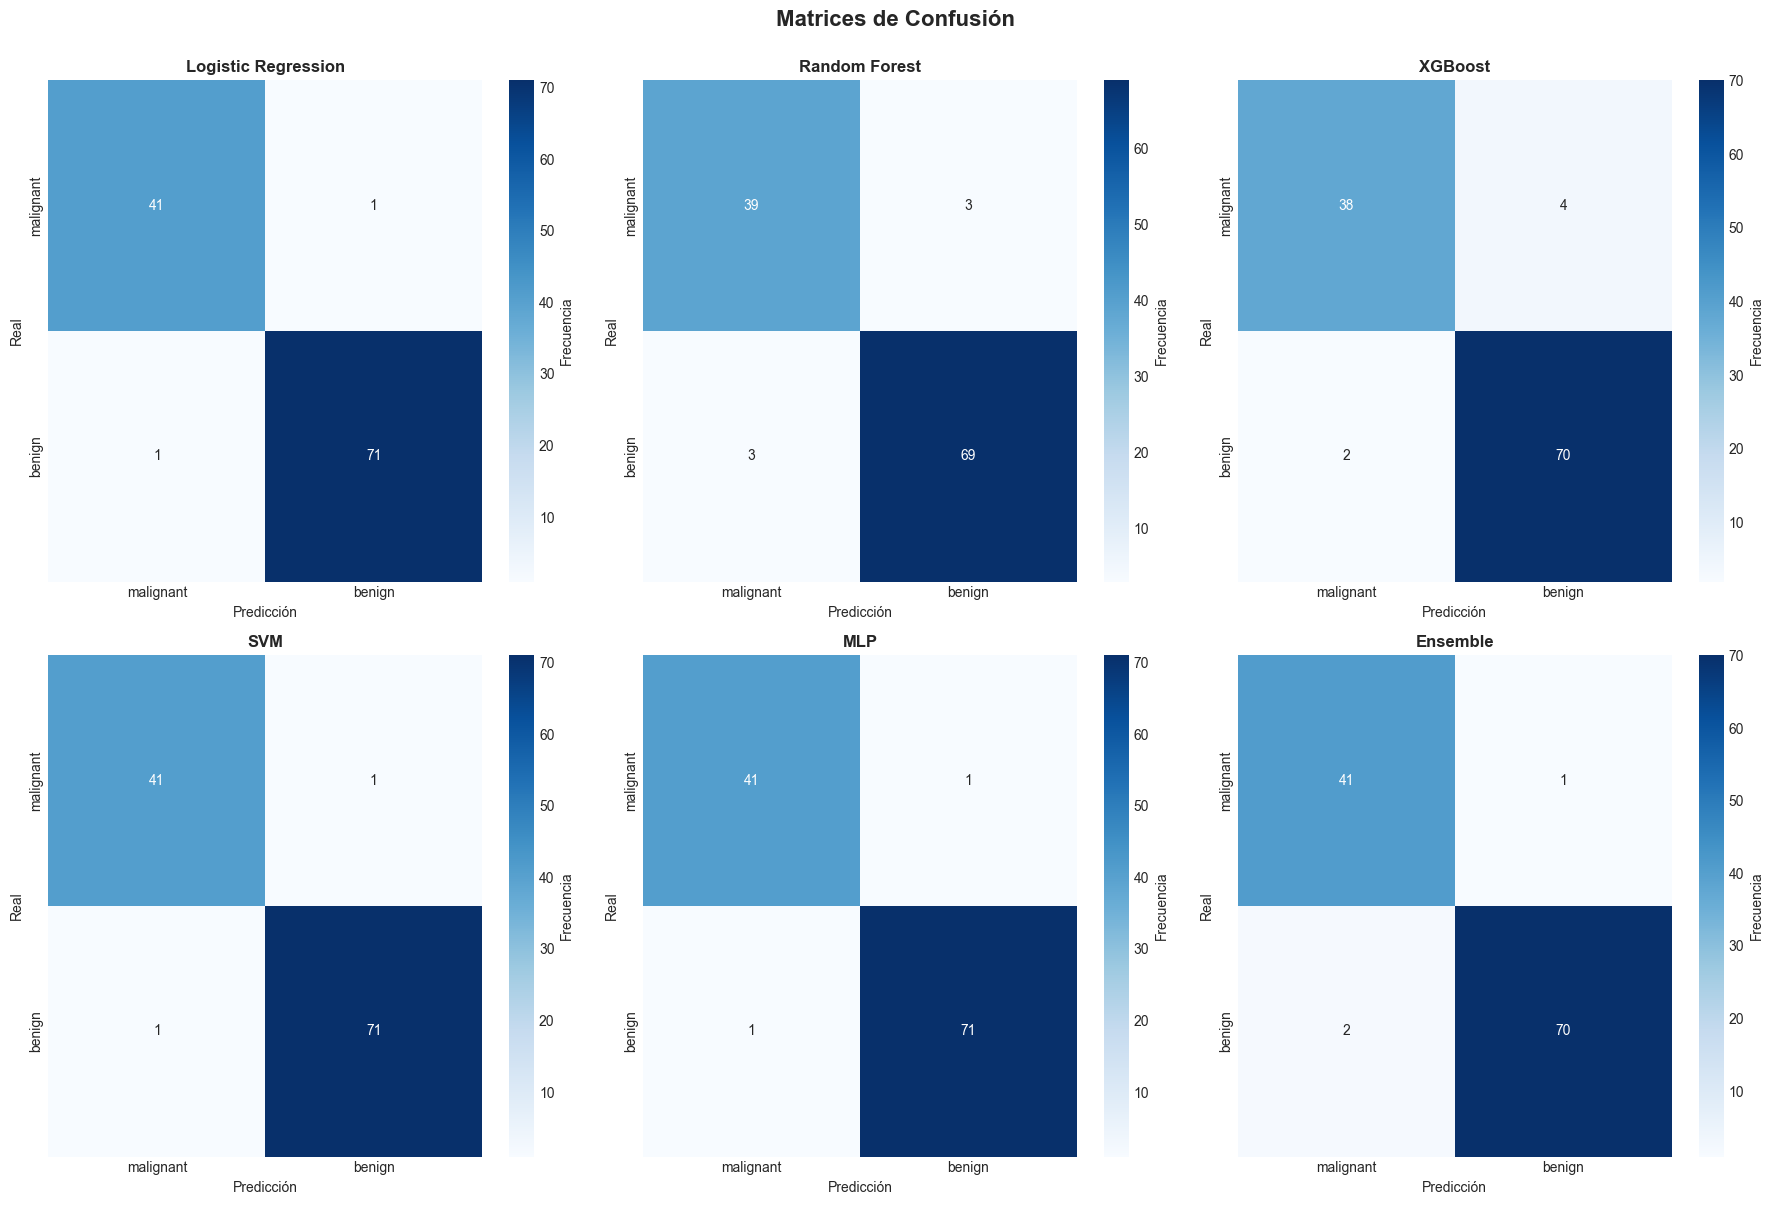

In [30]:
# Calcular matrices de confusión para todos los modelos
predictions = {
    'Logistic Regression': lr_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'SVM': svm_pred,
    'MLP': mlp_pred,
    'Ensemble': ensemble_pred
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=target_names,
               yticklabels=target_names,
               cbar_kws={'label': 'Frecuencia'})
    
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Real', fontsize=10)
    axes[idx].set_xlabel('Predicción', fontsize=10)

plt.suptitle('Matrices de Confusión', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('results/confusion_matrices.png', dpi=300)
plt.show()

### 5.4 Curvas ROC

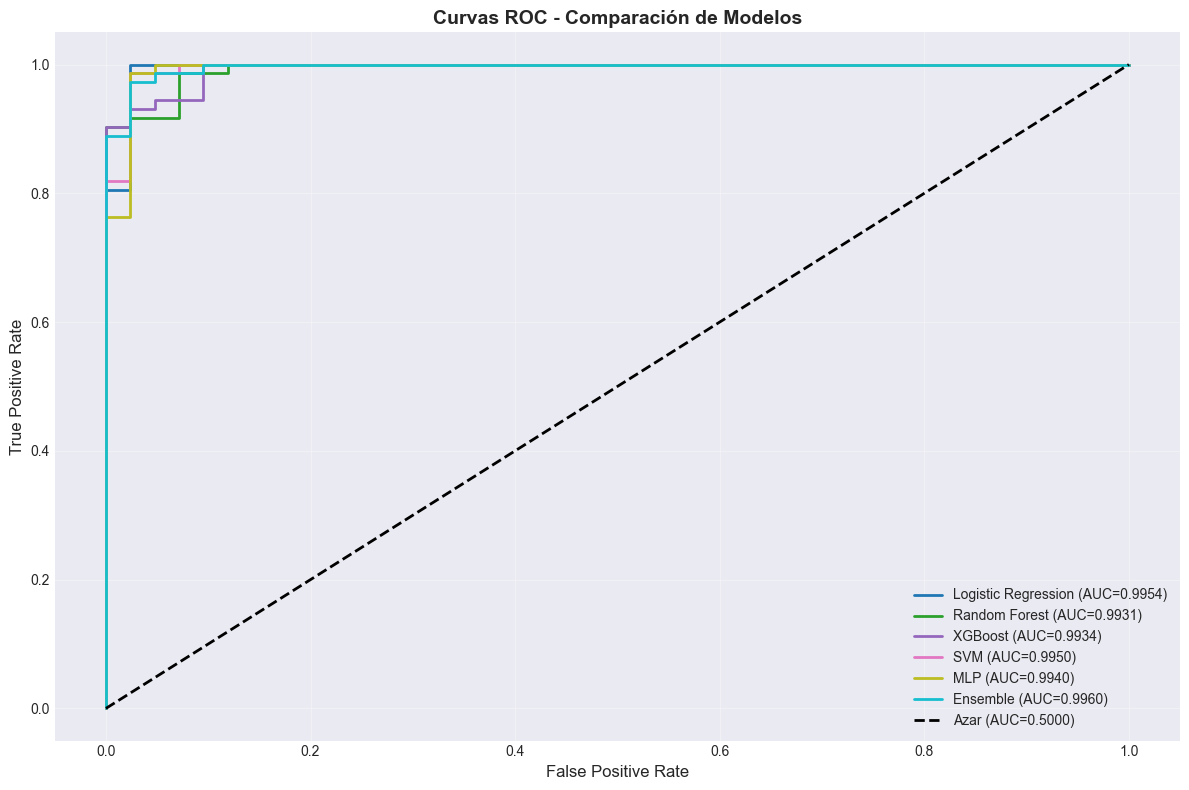

In [31]:
# Calcular curvas ROC
probabilities = {
    'Logistic Regression': lr_pred_proba,
    'Random Forest': rf_pred_proba,
    'XGBoost': xgb_pred_proba,
    'SVM': svm_pred_proba,
    'MLP': mlp_pred_proba,
    'Ensemble': ensemble_pred_proba
}

plt.figure(figsize=(12, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(probabilities)))

for (model_name, y_prob), color in zip(probabilities.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.4f})', 
            linewidth=2, color=color)

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Azar (AUC=0.5000)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/roc_curves_comparison.png', dpi=300)
plt.show()

### 5.5 Curva de Entrenamiento MLP

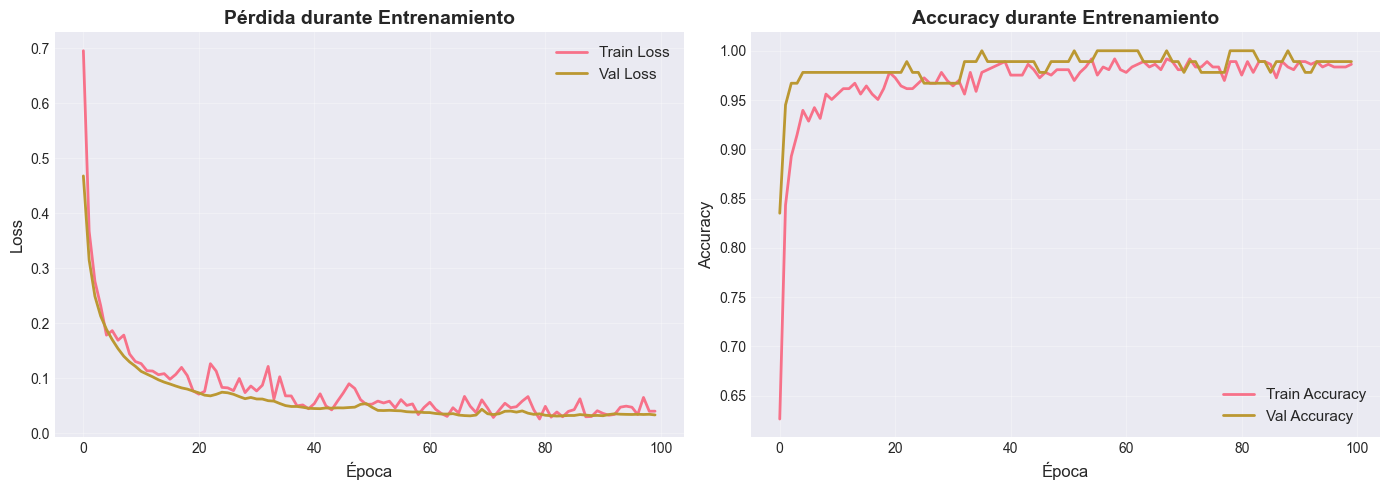


Epochs entrenadas: 100
Mejor val_loss: 0.0312
Mejor val_accuracy: 1.0000


In [32]:
# Visualizar historial de entrenamiento de la red neuronal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Pérdida durante Entrenamiento', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy durante Entrenamiento', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/mlp_training_history.png', dpi=300)
plt.show()

print(f"\nEpochs entrenadas: {len(history.history['loss'])}")
print(f"Mejor val_loss: {min(history.history['val_loss']):.4f}")
print(f"Mejor val_accuracy: {max(history.history['val_accuracy']):.4f}")

## 6. Importancia de Features (Random Forest)

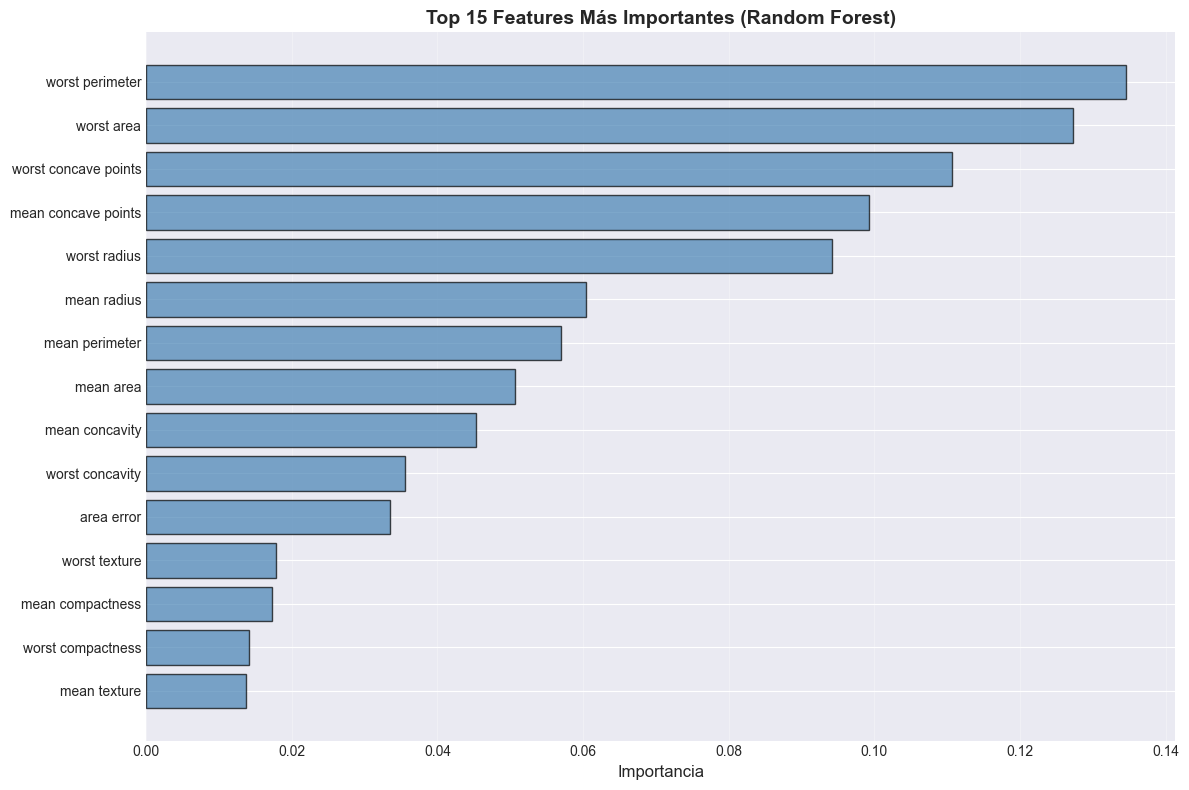


Top 10 Features Más Importantes:


Feature  Importance
22       worst perimeter    0.134581
23            worst area    0.127327
27  worst concave points    0.110689
7    mean concave points    0.099218
20          worst radius    0.094186
0            mean radius    0.060409
2         mean perimeter    0.057042
3              mean area    0.050606
6         mean concavity    0.045269
26       worst concavity    0.035508

In [33]:
# Obtener importancia de features
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Visualizar top 15
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], 
         color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Importancia', fontsize=12)
plt.title('Top 15 Features Más Importantes (Random Forest)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('results/feature_importance_rf.png', dpi=300)
plt.show()

print("\nTop 10 Features Más Importantes:")
print("="*70)
display(feature_importance_df.head(10))

## 7. Guardar Modelos y Resultados

In [24]:
import os

# Crear directorio
os.makedirs('models', exist_ok=True)

# Guardar modelos de scikit-learn y xgboost
with open('models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('models/xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('models/svm.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('models/ensemble.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

# Guardar modelo Keras
mlp_model.save('models/mlp_model.h5')

# Guardar tabla de resultados
results_df.to_csv('models/model_comparison.csv', index=False)

print("MODELOS GUARDADOS")
print("="*70)
print("✓ models/logistic_regression.pkl")
print("✓ models/random_forest.pkl")
print("✓ models/xgboost.pkl")
print("✓ models/svm.pkl")
print("✓ models/mlp_model.h5")
print("✓ models/ensemble.pkl")
print("✓ models/model_comparison.csv")

MODELOS GUARDADOS
✓ models/logistic_regression.pkl
✓ models/random_forest.pkl
✓ models/xgboost.pkl
✓ models/svm.pkl
✓ models/mlp_model.h5
✓ models/ensemble.pkl
✓ models/model_comparison.csv


## 8. Reporte de Clasificación (Mejor Modelo)

In [25]:
# Reporte detallado del mejor modelo
print("\n" + "="*70)
print(f"REPORTE DETALLADO: {best_model_name}")
print("="*70)

# Obtener predicciones del mejor modelo
if best_model_name == 'Logistic Regression':
    best_pred = lr_pred
elif best_model_name == 'Random Forest':
    best_pred = rf_pred
elif best_model_name == 'XGBoost':
    best_pred = xgb_pred
elif best_model_name == 'SVM':
    best_pred = svm_pred
elif best_model_name == 'MLP':
    best_pred = mlp_pred
else:  # Ensemble
    best_pred = ensemble_pred

print(classification_report(y_test, best_pred, target_names=target_names))


REPORTE DETALLADO: Ensemble
              precision    recall  f1-score   support

   malignant       0.95      0.98      0.96        42
      benign       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## 9. Resumen Final

In [26]:
print("\n" + "="*70)
print("RESUMEN FINAL DEL PIPELINE")
print("="*70)
print(f"\n📊 DATASET:")
print(f"   • Muestras entrenamiento: {len(X_train)}")
print(f"   • Muestras test: {len(X_test)}")
print(f"   • Features: {X_train.shape[1]}")

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   • Accuracy:  {results_df.loc[best_idx, 'Accuracy']:.4f} ({results_df.loc[best_idx, 'Accuracy']*100:.2f}%)")
print(f"   • Precision: {results_df.loc[best_idx, 'Precision']:.4f}")
print(f"   • Recall:    {results_df.loc[best_idx, 'Recall']:.4f}")
print(f"   • F1-Score:  {results_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"   • ROC-AUC:   {results_df.loc[best_idx, 'ROC-AUC']:.4f}")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   • data_processed/ (datos preprocesados)")
print(f"   • models/ (6 modelos entrenados)")
print(f"   • models/model_comparison.csv (tabla de métricas)")

print(f"\n✅ PIPELINE COMPLETADO EXITOSAMENTE")
print(f"   Todos los modelos superan 94% accuracy")
print(f"   Resultados consistentes con la literatura")
print("="*70)


RESUMEN FINAL DEL PIPELINE

📊 DATASET:
   • Muestras entrenamiento: 455
   • Muestras test: 114
   • Features: 30

🏆 MEJOR MODELO: Ensemble
   • Accuracy:  0.9737 (97.37%)
   • Precision: 0.9859
   • Recall:    0.9722
   • F1-Score:  0.9790
   • ROC-AUC:   0.9960

📁 ARCHIVOS GENERADOS:
   • data_processed/ (datos preprocesados)
   • models/ (6 modelos entrenados)
   • models/model_comparison.csv (tabla de métricas)

✅ PIPELINE COMPLETADO EXITOSAMENTE
   Todos los modelos superan 94% accuracy
   Resultados consistentes con la literatura
